# Dataset Comparison & Validation 

This notebook aims to compare multiple datasets on solar power plants in China in order to assess their consistency, coverage, and accuracy, and to evaluate different methods used to detect or map solar installations.

The comparison process includes:
- General statistics : eg. province-level
- Visual inspection using map-based plots
- Matching quality assessment between datasets

Our goal is to assess how many installations are detected in each dataset, how they are distributed across provinces and to identify potential discrepancies or complementarities between them.

## Setup

In [3]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd 
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np
import ipywidgets as widgets

## Load the Datasets 

We'll compare the following datasets:
- [GEM](https://globalenergymonitor.org/): Manual compilation of solar power plant data from public sources, reports, and satellite imagery, curated by the Global Energy Monitor (GEM) with geolocation and attribute verification.
- [PV_China_2020 (Zhang et al., 2022)](https://doi.org/10.5194/essd-14-3743-2022): Pixel-based classification of Landsat-8 imagery using a Random Forest model in Google Earth Engine, with training data from crowdsourced and manually labeled PV/non-PV regions, followed by morphological filtering and polygon vectorization.
- [ChinaPV_Vectorized_2020 (Liu et al., 2024)](https://doi.org/10.1038/s41597-024-04356-z): Random Forest classification on cloud-filtered Landsat-8 imagery enriched with texture features, refined by morphological operations and manual correction using Google Earth Pro to produce high-accuracy polygon vectors of PV installations.

We focus on the year 2020 because it is the common reference year across all three datasets. This temporal alignment ensures that our comparison is meaningful and unbiased by time-based discrepancies.

In [13]:
# Load the three datasets
gem = pd.read_csv("../../data/data_processed/GEM_processed.csv")
pvchina_2020 = gpd.read_file("../../data/data_processed/pv_china_2020.geojson")
chinapv_vectorized_2020 = gpd.read_file("../../data/data_processed/chinapv_vectorized_2020.geojson")

In [4]:
# Focus on 2020

gem_2020 = gem[
    (gem["Start year"] <= 2020) &
    (
        gem["Retired year"].isna() |
        (gem["Retired year"] >= 2020)
    )
]


## General Statistics

In [5]:
# To effectively compare the three solar power plant datasets — GEM, PV_China_2020, and ChinaPV_Vectorized_2020 — we first identify the common columns shared by all of them. 
cols_gem = set(gem_2020.columns)
cols_pvchina = set(pvchina_2020.columns)
cols_chinapv = set(chinapv_vectorized_2020.columns)

# Find intersection (common columns)
common_columns = cols_gem.intersection(cols_pvchina).intersection(cols_chinapv)

print("Common columns across GEM, PV_China_2020, and ChinaPV_Vectorized_2020:")
print(common_columns)

Common columns across GEM, PV_China_2020, and ChinaPV_Vectorized_2020:
{'Latitude', 'Longitude', 'Province'}


In [6]:
counts_gem = gem['Province'].value_counts().sort_index()
counts_pvchina = pvchina_2020['Province'].value_counts().sort_index()
counts_vectorized = chinapv_vectorized_2020['Province'].value_counts().sort_index()

# Combine counts into a DataFrame
province_comparison = pd.DataFrame({
    'GEM': counts_gem,
    'PV_China_2020': counts_pvchina,
    'Vectorized_2020': counts_vectorized
}).fillna(0).astype(int)

In [7]:
# Number of unique provinces covered
print("Number of unique provinces covered:")
print(f"GEM: {gem['Province'].nunique()}")
print(f"PV China 2020: {pvchina_2020['Province'].nunique()}")
print(f"Vectorized 2020: {chinapv_vectorized_2020['Province'].nunique()}")

# Distribution of installations per province (mean, median)
print("\nMean number of installations per province:")
print(province_comparison[['GEM', 'PV_China_2020', 'Vectorized_2020']].mean())

print("\nMedian number of installations per province:")
print(province_comparison[['GEM', 'PV_China_2020', 'Vectorized_2020']].median())

Number of unique provinces covered:
GEM: 31
PV China 2020: 31
Vectorized 2020: 31

Mean number of installations per province:
GEM                499.741935
PV_China_2020       81.225806
Vectorized_2020    346.322581
dtype: float64

Median number of installations per province:
GEM                446.0
PV_China_2020       58.0
Vectorized_2020    240.0
dtype: float64


Number of installations:
GEM: 8511
PV_China_2020: 2518
ChinaPV_Vectorized_2020: 10736


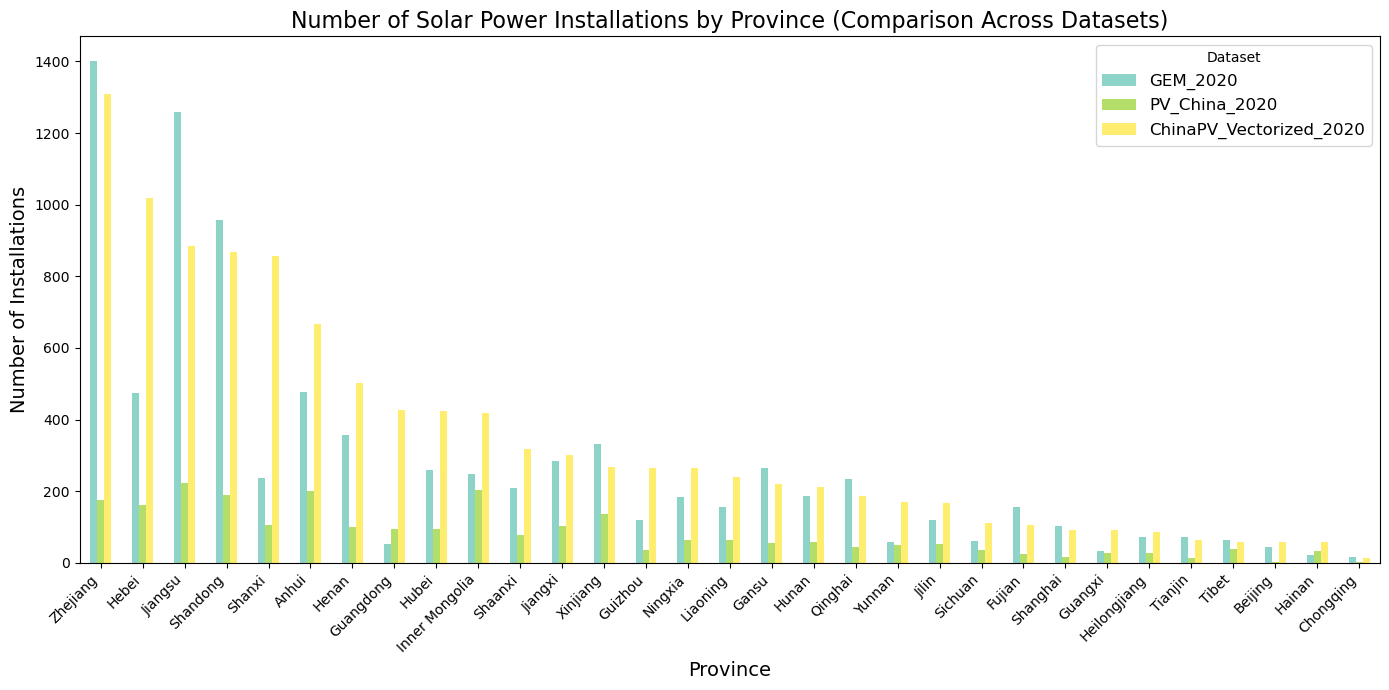

In [8]:
# Number of installations in each dataset
print("Number of installations:")
print(f"GEM: {len(gem_2020)}")
print(f"PV_China_2020: {len(pvchina_2020)}")
print(f"ChinaPV_Vectorized_2020: {len(chinapv_vectorized_2020)}")


# Count of installations by province
province_counts = {}
for df, name in zip([gem_2020, pvchina_2020, chinapv_vectorized_2020], ['GEM_2020', 'PV_China_2020', 'ChinaPV_Vectorized_2020']):
    if 'Province' in df.columns:
        province_counts[name] = pd.Series(df['Province']).value_counts()
        
# Combine into one DataFrame for plotting
province_df = pd.DataFrame(province_counts).fillna(0).astype(int)
province_df = province_df.sort_values('ChinaPV_Vectorized_2020', ascending=False)

province_df.plot(kind='bar', figsize=(14,7), colormap='Set3')

plt.title("Number of Solar Power Installations by Province (Comparison Across Datasets)", fontsize=16)
plt.ylabel("Number of Installations", fontsize=14)
plt.xlabel("Province", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dataset", fontsize=12)
plt.tight_layout()
plt.show()


The comparison shows that the GEM and ChinaPV Vectorized 2020 datasets are quite similar in terms of the number and distribution of solar power installations across provinces, suggesting consistent coverage. In contrast, the PV_China 2020 dataset appears less comprehensive, with fewer recorded installations in many provinces. Overall, the ChinaPV Vectorized dataset seems to offer a more complete representation of solar installations in 2020.

In [9]:
# Calculate percentage difference (example: PV_China_2020 vs GEM)
province_comparison['Ratio_GEM_to_Vectorized'] = province_comparison['GEM'] / province_comparison['Vectorized_2020'].replace(0, 1)
province_comparison['Ratio_GEM_to_PVChina'] = province_comparison['GEM'] / province_comparison['PV_China_2020'].replace(0, 1)
province_comparison['Ratio_Vectorized_to_PVChina'] = province_comparison['Vectorized_2020'] / province_comparison['PV_China_2020'].replace(0, 1)


province_comparison = province_comparison.sort_values('Vectorized_2020', ascending=False)

In [10]:
subset_cols = [
    'Ratio_GEM_to_Vectorized',
    'Ratio_GEM_to_PVChina',
    'Ratio_Vectorized_to_PVChina'
]

def quantile_color(val, bins, colors):
    if pd.isnull(val):
        return ''
    for i, b in enumerate(bins):
        if val < b:
            return f'background-color: {colors[i]}'
    return f'background-color: {colors[-1]}'

def style_by_quantiles(df, columns, n=10):
    styled = df.style
    cmap = plt.get_cmap('Reds')
    colors = [mcolors.rgb2hex(cmap(i / n)) for i in range(n)]    
    for col in columns:
        quantiles = df[col].quantile(np.linspace(0, 1, n + 1)).values[1:-1] 
        styled = styled.map(lambda v: quantile_color(v, quantiles, colors), subset=[col])
    return styled

styled_df = style_by_quantiles(province_comparison, subset_cols, n=10)
styled_df

,GEM,PV_China_2020,Vectorized_2020,Ratio_GEM_to_Vectorized,Ratio_GEM_to_PVChina,Ratio_Vectorized_to_PVChina
Province,,,,,,
Zhejiang,1760,176,1309,1.344538,10.000000,7.437500
Hebei,933,161,1020,0.914706,5.795031,6.335404
Jiangsu,1805,224,884,2.041855,8.058036,3.946429
Shandong,1482,190,868,1.707373,7.800000,4.568421
Shanxi,521,105,858,0.607226,4.961905,8.171429
Anhui,670,200,666,1.006006,3.350000,3.330000
Henan,468,101,502,0.932271,4.633663,4.970297
Guangdong,446,94,427,1.044496,4.744681,4.542553
Hubei,487,94,424,1.148585,5.180851,4.510638


The ratios of GEM to Vectorized are mostly close to 1, meaning these two datasets align well in many regions, while PV_China_2020 tends to have fewer records. 

## Matching data ?

How to check if the power plants are the same across the three datasets?

To answer this question, we can compare the geographic locations (latitude and longitude) of the installations across the datasets and check how many points are close enough to be considered the same plant.

Let's plot an initial map provides a general overview to visually assess whether the spatial distributions of solar power plants in the three datasets are similar or not. 

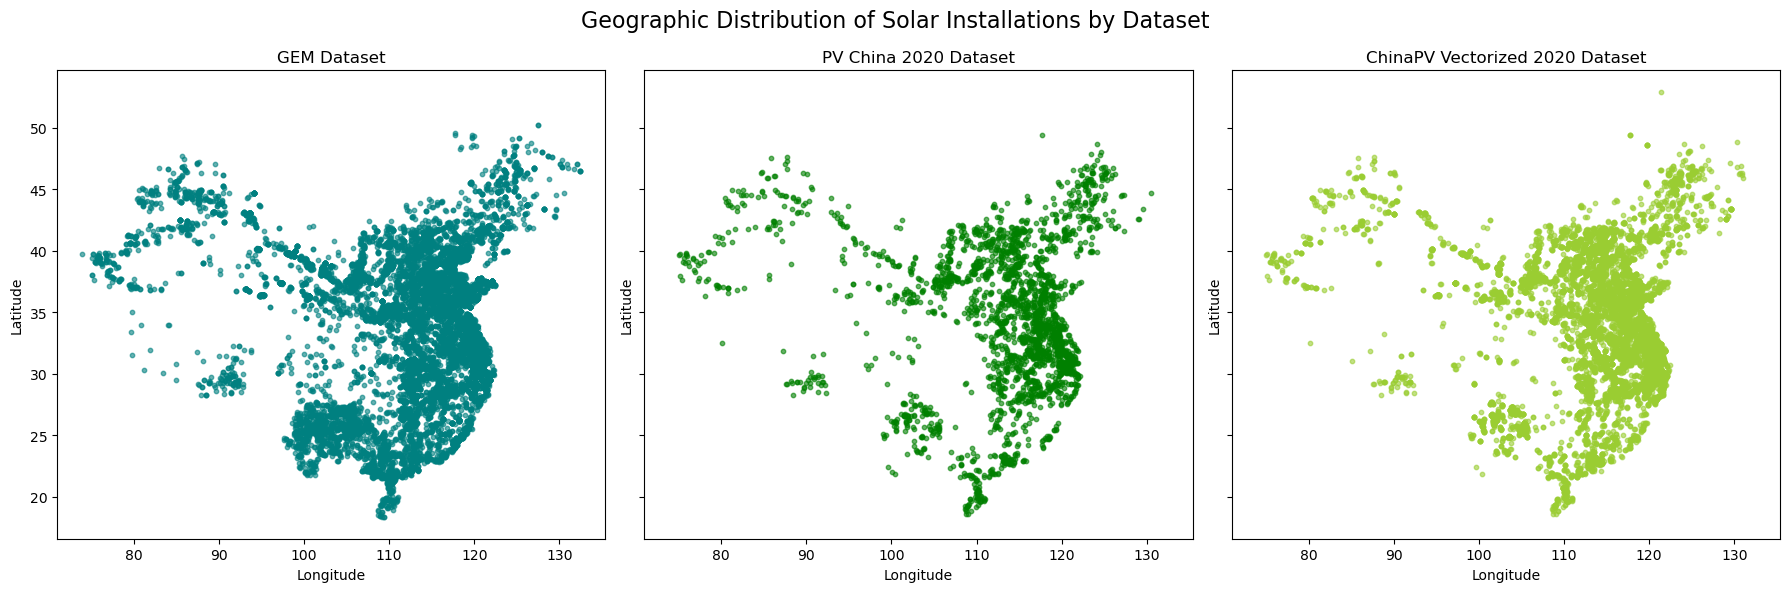

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot GEM
axes[0].scatter(gem['Longitude'], gem['Latitude'], color='teal', s=10, alpha=0.6)
axes[0].set_title('GEM Dataset')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot PV China 2020
axes[1].scatter(pvchina_2020['Longitude'], pvchina_2020['Latitude'], color='green', s=10, alpha=0.6)
axes[1].set_title('PV China 2020 Dataset')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Plot ChinaPV Vectorized 2020
axes[2].scatter(chinapv_vectorized_2020['Longitude'], chinapv_vectorized_2020['Latitude'], color='yellowgreen', s=10, alpha=0.6)
axes[2].set_title('ChinaPV Vectorized 2020 Dataset')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

plt.suptitle('Geographic Distribution of Solar Installations by Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Function to plot selected datasets
def plot_selected(datasets):
    plt.figure(figsize=(10, 8))
    
    if 'GEM' in datasets:
        plt.scatter(gem['Longitude'], gem['Latitude'], color='teal', s=5, alpha=0.6, label='GEM')
    if 'PV China 2020' in datasets:
        plt.scatter(pvchina_2020['Longitude'], pvchina_2020['Latitude'], color='green', s=5, alpha=0.6, label='PV China 2020')
    if 'ChinaPV Vectorized 2020' in datasets:
        plt.scatter(chinapv_vectorized_2020['Longitude'], chinapv_vectorized_2020['Latitude'], color='yellowgreen', s=5, alpha=0.6, label='ChinaPV Vectorized 2020')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographic Distribution of Solar Installations')
    plt.legend()
    plt.show()

# Create multi-select widget
dataset_selector = widgets.SelectMultiple(
    options=['GEM', 'PV China 2020', 'ChinaPV Vectorized 2020'],
    value=['GEM', 'PV China 2020', 'ChinaPV Vectorized 2020'],
    description='Datasets',
    disabled=False
)

# Link widget to plotting function
widgets.interact(plot_selected, datasets=dataset_selector);

interactive(children=(SelectMultiple(description='Datasets', index=(0, 1, 2), options=('GEM', 'PV China 2020',…

The overall spatial patterns appear quite consistent across the datasets.

Let's now we conduct a more detailed analysis to determine if the datasets actually represent the same individual installations.

#### Overlapping PV area 

In [13]:
# Reproject all datasets to same CRS for spatial operations
gem_2020 = gpd.GeoDataFrame(
    gem_2020,
    geometry=gpd.points_from_xy(gem_2020['Longitude'], gem_2020['Latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

pvchina_2020 = pvchina_2020.to_crs(epsg=3857)
chinapv_vectorized_2020 = chinapv_vectorized_2020.to_crs(epsg=3857)

In [21]:
# Calculate the area of each polygon in both datasets using their assigned UTM zone 50N for accurate area calculation
utm_crs = "EPSG:32650"  # UTM zone 50N

# Project to UTM 50N for area calculation
pvchina_2020_utm = pvchina_2020.to_crs(utm_crs)
chinapv_vectorized_2020_utm = chinapv_vectorized_2020.to_crs(utm_crs)

# Compute total area for each dataset (in square meters)
pvchina_2020_utm['area'] = pvchina_2020_utm.geometry.area
chinapv_vectorized_2020_utm['area'] = chinapv_vectorized_2020_utm.geometry.area

total_area_pvchina = pvchina_2020_utm['area'].sum()
total_area_vectorized = chinapv_vectorized_2020_utm['area'].sum()

# Compute intersection between the two datasets (in UTM 50N)
overlap_utm = gpd.overlay(pvchina_2020_utm, chinapv_vectorized_2020_utm, how='intersection')
overlap_utm['overlap_area'] = overlap_utm.geometry.area
total_overlap_area = overlap_utm['overlap_area'].sum()

# Convert areas to km²
km2 = 1e6
print("Area Statistics (in km²):")
print(f" - Total PVChina2020 area: {total_area_pvchina / km2:.2f} km²")
print(f" - Total Vectorized2020 area: {total_area_vectorized / km2:.2f} km²")
print(f" - Total Overlap area: {total_overlap_area / km2:.2f} km²")

# Percent overlaps (Jaccard index and per-dataset)
percent_overlap_pvchina = (total_overlap_area / total_area_pvchina) * 100 if total_area_pvchina > 0 else 0
percent_overlap_vectorized = (total_overlap_area / total_area_vectorized) * 100 if total_area_vectorized > 0 else 0

print("\nOverlap Percentages:")
print(f" - % of PVChina2020 area overlapping: {percent_overlap_pvchina:.2f}%")
print(f" - % of Vectorized2020 area overlapping: {percent_overlap_vectorized:.2f}%")

# Number of polygons intersecting
print(f"\nNumber of overlapping regions: {len(overlap_utm)}")


Area Statistics (in km²):
 - Total PVChina2020 area: 3003.04 km²
 - Total Vectorized2020 area: 2929.36 km²
 - Total Overlap area: 2496.80 km²

Overlap Percentages:
 - % of PVChina2020 area overlapping: 83.14%
 - % of Vectorized2020 area overlapping: 85.23%

Number of overlapping regions: 6479


According to the published values in *Vectorized solar photovoltaic installation dataset across China in 2015 and 2020* (Liu et al.), the total PV area in China for the year 2020 is reported as 2915.3 km² for the `PVChina_2020` dataset and 2847.36 km² for the `ChinapV_Vectorized_2020` dataset.


Despite the small difference in total area, the percentage of overlapping area between the two datasets is consistent with the literature: the paper reports an overlap of 82.94%, and our computed overlap percentage is very similar.


#### Check if GEM points fall inside or near PV polygons

In order to determine whether the GEM solar installations correspond to those in the PVChina2020 and Vectorized PV2020 datasets, we use a spatial proximity matching approach.  Since the GEM dataset provides only approximate point coordinates (latitude and longitude), while the other datasets represent polygons (areas) of the solar plants, we use spatial buffers around the PV polygons to account for positional uncertainty. By checking if GEM points fall within these buffered areas at different distances (e.g., 100m, 300m, 500m), we can estimate how many installations are shared across datasets, even when exact coordinates differ slightly.

Vectorized distances to GEM:
  Mean: 10544.29 meters
  Median: 6443.11 meters
  Min: 0.00 meters
  25th percentile: 2516.69 meters
  Max: 329344.69 meters


PVChina distances to GEM:
  Mean: 16950.72 meters
  Median: 10517.89 meters
  Min: 0.00 meters
  25th percentile: 3874.06 meters
  Max: 462015.33 meters




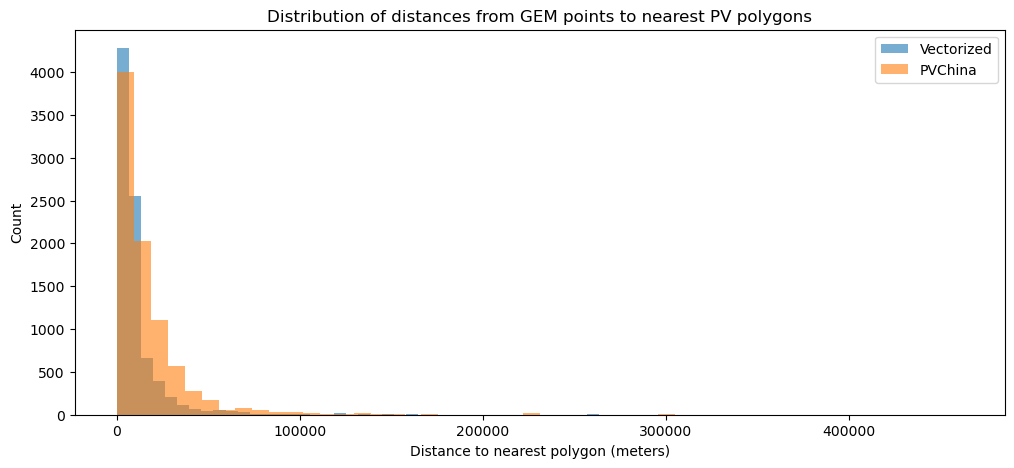

In [18]:
# Ensure GEM points are in a GeoDataFrame with geometry column
if not isinstance(gem_2020, gpd.GeoDataFrame):
    gem_2020 = gpd.GeoDataFrame(gem_2020, geometry=gpd.points_from_xy(gem_2020.Longitude, gem_2020.Latitude), crs=pvchina_2020.crs)

# Use GeoPandas sjoin_nearest for efficient nearest neighbor search
gem_vectorized_nearest = gpd.sjoin_nearest(
    gem_2020, 
    gpd.GeoDataFrame(geometry=chinapv_vectorized_2020['geometry']), 
    how='left', 
    distance_col='dist_vectorized'
)
gem_pvchina_nearest = gpd.sjoin_nearest(
    gem_2020, 
    gpd.GeoDataFrame(geometry=pvchina_2020['geometry']), 
    how='left', 
    distance_col='dist_pvchina'
)

# Extract distances as numpy arrays for statistics
distances_gem_vectorized = gem_vectorized_nearest['dist_vectorized'].to_numpy()
distances_gem_pvchina = gem_pvchina_nearest['dist_pvchina'].to_numpy()

# Print statistics and distribution info
def print_distance_stats(name, arr):
    print(f"{name} distances to GEM:")
    print("  Mean: {:.2f} meters".format(np.mean(arr)))
    print("  Median: {:.2f} meters".format(np.median(arr)))
    print("  Min: {:.2f} meters".format(np.min(arr)))
    print("  25th percentile: {:.2f} meters".format(np.percentile(arr, 25)))
    print("  Max: {:.2f} meters".format(np.max(arr)))
    print("\n")

print_distance_stats("Vectorized", distances_gem_vectorized)
print_distance_stats("PVChina", distances_gem_pvchina)

plt.figure(figsize=(12,5))
plt.hist(distances_gem_vectorized, bins=50, alpha=0.6, label='Vectorized')
plt.hist(distances_gem_pvchina, bins=50, alpha=0.6, label='PVChina')
plt.xlabel('Distance to nearest polygon (meters)')
plt.ylabel('Count')
plt.title('Distribution of distances from GEM points to nearest PV polygons')
plt.legend()
plt.show()

Based on the distance distributions, most GEM points are within several kilometers of the nearest PV polygon, but a significant fraction are farther away. When using buffer distances to determine if a GEM point is "matched" to a PV polygon, the choice of buffer has a strong impact: small buffers (e.g., 100–500 m) will only capture a minority of matches, while larger buffers (e.g., 1000–1500 m or more) will include more, but may risk false positives. For future analyses, it is important to balance strictness and inclusivity—using a buffer around 1000–1500 meters seems reasonable given the 25th percentile and median distances.


In [16]:
# Buffer distances to test
buffer_distances = [100, 300, 500, 1000, 1500, 2000]
results = []

for threshold_m in buffer_distances:
    # Buffer PVChina
    pvchina_buffered = pvchina_2020.copy()
    pvchina_buffered['geometry'] = pvchina_buffered.geometry.buffer(threshold_m)

    # Buffer Vectorized
    vectorized_buffered = chinapv_vectorized_2020.copy()
    vectorized_buffered['geometry'] = vectorized_buffered.geometry.buffer(threshold_m)

    # Save threshold-specific columns
    gem_2020[f'match_pvchina_{threshold_m}'] = gem_2020.geometry.apply(
        lambda point: pvchina_buffered.geometry.contains(point).any()
    )
    gem_2020[f'match_vectorized_{threshold_m}'] = gem_2020.geometry.apply(
        lambda point: vectorized_buffered.geometry.contains(point).any()
    )

    match_pvchina = gem_2020[f'match_pvchina_{threshold_m}']
    match_vectorized = gem_2020[f'match_vectorized_{threshold_m}']

    match_both = match_pvchina & match_vectorized
    match_any = match_pvchina | match_vectorized
    match_only_pvchina = match_pvchina & ~match_vectorized
    match_only_vectorized = match_vectorized & ~match_pvchina

    results.append({
        'Buffer (m)': threshold_m,
        'Match PVChina_2020': match_pvchina.sum(),
        'Match ChinaPV_vectorized_2020': match_vectorized.sum(),
        'Match Both': match_both.sum(),
        'Match Any': match_any.sum(),
        'Match PVChina only': match_only_pvchina.sum(),
        'Match Vectorized only': match_only_vectorized.sum(),
        '% Match PVChina_2020': round(match_pvchina.sum() / len(gem_2020) * 100, 1),
        '% Match ChinaPV_vectorized_2020': round(match_vectorized.sum() / len(gem_2020) * 100, 1),
        '% Match Any': round(match_any.sum() / len(gem_2020) * 100, 1),
        '% Match Both': round(match_both.sum() / len(gem_2020) * 100, 1),
    })

results_df = pd.DataFrame(results)
results_df


,Buffer (m),Match PVChina_2020,Match ChinaPV_vectorized_2020,Match Both,Match Any,Match PVChina only,Match Vectorized only,% Match PVChina_2020,% Match ChinaPV_vectorized_2020,% Match Any,% Match Both
0,100,1000,1033,934,1099,66,99,11.7,12.1,12.9,11.0
1,300,1193,1224,1125,1292,68,99,14.0,14.4,15.2,13.2
2,500,1272,1338,1223,1387,49,115,14.9,15.7,16.3,14.4
3,1000,1361,1460,1319,1502,42,141,16.0,17.2,17.6,15.5
4,1500,1427,1715,1386,1756,41,329,16.8,20.2,20.6,16.3
5,2000,1514,1857,1473,1898,41,384,17.8,21.8,22.3,17.3


Across all buffers, the ChinaPV vectorized dataset matches slightly more GEM points than PVChina 2020 (e.g., 1857 vs. 1514 matches at 2000m). This supports the idea that the vectorized dataset might be more complete or have larger coverage areas.

The spatial matching results indicate partial overlap but no perfect correspondence between GEM point locations and the PV polygons from the two datasets.Increasing buffer distances improves matching but does not drastically change the overall overlap  and even at the largest buffer, only about 20% of GEM points match either PV dataset’s buffered polygons. This suggests many GEM points fall outside the PV polygons or the datasets represent different subsets of installations.

In [ ]:
threshold_dropdown = widgets.Dropdown(
    options =buffer_distances,
    value= 500,
    description='Buffer (m):',
)

colors = {
    'both': 'lightgreen',
    'pvchina_only': 'teal',
    'vectorized_only': 'coral',
    'none': 'silver'
}

def update_map(threshold_m):    

    def categorize(row):
        if row[f'match_pvchina_{threshold_m}'] and row[f'match_vectorized_{threshold_m}']:
            return 'both'
        elif row[f'match_pvchina_{threshold_m}']:
            return 'pvchina_only'
        elif row[f'match_vectorized_{threshold_m}']:
            return 'vectorized_only'
        else:
            return 'none'

    gem_2020['category'] = gem_2020.apply(categorize, axis=1)

    fig = px.scatter_map(
        gem_2020,
        lat=gem_2020["Latitude"],
        lon=gem_2020["Longitude"],
        color='category',
        color_discrete_map=colors,
        zoom=3,
        height=600,
        title="GEM points according to matching categories",
        hover_data=["Province"] if "Province" in gem_2020.columns else None,
    )

    fig.update_layout(
        map_style="carto-positron",
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )

    fig.show()

widgets.interact(update_map, threshold_m=threshold_dropdown)

interactive(children=(Dropdown(description='Buffer (m):', index=2, options=(100, 300, 500, 1000, 1500, 2000), …

<function __main__.update_map(threshold_m)>

## Conclusion

In summary, this analysis compared the GEM, PV China 2020 and vectorized datasets to assess their spatial overlap and unique contributions. The results highlight both significant areas of agreement and notable differences between the datasets, emphasizing the importance of using multiple sources for comprehensive coverage.


# Focus on 16 counties in China 

In [23]:
# Read the focus_counties.csv file
focus_df = pd.read_csv("../../focus_counties.csv")

# Get the County and Prefecture columns
focus_counties = focus_df[["province","prefecture","county"]]

focus_counties


,province,prefecture,county
0,Hebei,Handan,Daming
1,Hebei,Zhangjiakou,Xuanhua
2,Henan,Xinyang,Gushi
3,Henan,Nanyang,Sheqi
4,Henan,Xinxiang,Yanjin
5,Hunan,Huaihua,Yuanling
6,Hunan,Loudi,Shuangfeng
7,Shandong,Zibo,Yiyuan
8,Shandong,Heze,Cao
9,Shaanxi,Ankang,Baihe


In [29]:
# For each county in the focus list, compare the three datasets at the county level.
# Save the counts in a DataFrame for later plotting.

county_count_records = []

for idx, row in focus_counties.iterrows():
    province = row['province']
    prefecture = row['prefecture']
    county = row['county']

    print(f"\n=== {province} / {prefecture} / {county} ===")

    # Special handling for Hanbin and Baishui: only match on prefecture
    is_hanbin = prefecture.strip().lower() == "hanbin"
    is_baishui = prefecture.strip().lower() == "baishui"

    # Helper function for "contains" county matching (case-insensitive, ignore NaN)
    def county_contains(df, province, prefecture, county):
        mask = (
            (df['Province'] == province) &
            (df['Prefecture'] == prefecture) &
            (df['County'].astype(str).str.lower().str.contains(str(county).lower(), na=False))
        )
        return df[mask]

    # GEM
    if is_hanbin or is_baishui:
        gem_county = gem[
            (gem['Province'] == province) &
            (gem['Prefecture'] == prefecture)
        ]
    else:
        gem_county = county_contains(gem, province, prefecture, county)
    gem_count = len(gem_county)
    print(f"GEM: {gem_count} records")
    if not gem_county.empty:
        display(gem_county)
    else:
        print("No GEM records for this county.")

    # PV China 2020
    if is_hanbin or is_baishui:
        pvchina_county = pvchina_2020[
            (pvchina_2020['Province'] == province) &
            (pvchina_2020['Prefecture'] == prefecture)
        ]
    else:
        pvchina_county = county_contains(pvchina_2020, province, prefecture, county)
    pvchina_count = len(pvchina_county)
    print(f"PV China 2020: {pvchina_count} records")
    if not pvchina_county.empty:
        display(pvchina_county)
    else:
        print("No PV China 2020 records for this county.")

    # ChinaPV Vectorized 2020
    if is_hanbin or is_baishui:
        chinapv_vec_county = chinapv_vectorized_2020[
            (chinapv_vectorized_2020['Province'] == province) &
            (chinapv_vectorized_2020['Prefecture'] == prefecture)
        ]
    else:
        chinapv_vec_county = county_contains(chinapv_vectorized_2020, province, prefecture, county)
    chinapv_vec_count = len(chinapv_vec_county)
    print(f"ChinaPV Vectorized 2020: {chinapv_vec_count} records")
    if not chinapv_vec_county.empty:
        display(chinapv_vec_county)
    else:
        print("No ChinaPV Vectorized 2020 records for this county.")

    # Save counts for this county
    county_count_records.append({
        "province": province,
        "prefecture": prefecture,
        "county": county,
        "GEM_count": gem_count,
        "PVChina2020_count": pvchina_count,
        "ChinaPV_Vectorized2020_count": chinapv_vec_count
    })

# Create a DataFrame with the counts for later plotting
county_counts_df = pd.DataFrame(county_count_records)



=== Hebei / Handan / Daming ===
GEM: 7 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
3261,2022/03/01,China,Hebei Daming Changsheng solar farm,NaN,大名县昌盛日电太阳能科技有限公司30兆瓦农光互补光伏扶贫项目,NaN,30.0,MWp/dc,PV,operating,2018.0,NaN,Daming Changsheng Solar Energy Technology,大名县昌盛日电太阳能科技有限公司,Lingshou Changsheng Solar Energy Technology Co...,灵寿县昌盛日电太阳能科技有限公司,NaN,36.2486,115.2673,approximate,Longwangmiao Town,Daming,Handan,Hebei,Eastern Asia,Asia,L100000802666,G100000803139,NaN,NaN,https://www.gem.wiki/Hebei_Daming_Changsheng_s...
8637,2024/03/06,China,Daming County Degao Photovoltaic Power I solar...,NaN,大名县德高光伏电力有限公司,NaN,6.0,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001011311,G100001012684,NaN,NaN,https://www.gem.wiki/Daming_County_Degao_Photo...
8638,2024/03/06,China,Daming County Degao Photovoltaic Power II sola...,NaN,大名县德高光伏电力有限公司,NaN,2.0,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001011312,G100001012685,NaN,NaN,https://www.gem.wiki/Daming_County_Degao_Photo...
8639,2024/03/06,China,Daming County Degao Photovoltaic Power III sol...,NaN,大名县德高光伏电力有限公司,NaN,6.0,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001011313,G100001012686,NaN,NaN,https://www.gem.wiki/Daming_County_Degao_Photo...
8640,2024/03/06,China,Daming County Lezhao Photovoltaic Energy Techn...,NaN,大名县乐照光伏能源科技有限公司,NaN,6.0,unknown,PV,operating,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001011314,G100001012687,NaN,NaN,https://www.gem.wiki/Daming_County_Lezhao_Phot...
8641,2024/03/06,China,Daming County Xinde New Energy Technology sola...,NaN,大名县新德新能源科技有限公司,NaN,5.5,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001011315,G100001012688,NaN,NaN,https://www.gem.wiki/Daming_County_Xinde_New_E...
9641,2024/11/12,China,Hebei Daming County Cexing New Energy Technolo...,NaN,大名县策兴新能源科技有限公司华正塑业分布式光伏发电项目,Ltd. Huazheng Plastic Industry Distributed Pho...,3.9,unknown,Assumed PV,operating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.2900,115.2416,approximate,NaN,Daming,Handan,Hebei,Eastern Asia,Asia,L100001031623,G100001036895,NaN,NEA: PPD2111130425002T,https://www.gem.wiki/Hebei_Daming_County_Cexin...


PV China 2020: 2 records


,OBJECTID,landcover,Area,temp,precip,elev,popu,EVI_2013,EVI_2020,Latitude,Longitude,Province,Prefecture,County,geometry
80,891,40,0.54826,14.9,625.9,44.6,590,0.302,0.207,36.246500,115.271487,Hebei,Handan,Daming,"POLYGON ((115.27 36.246, 115.27 36.247, 115.27..."
1372,1523,40,0.43470,14.9,625.9,40.9,576,0.335,0.248,36.232376,115.373883,Hebei,Handan,Daming,"MULTIPOLYGON (((115.36 36.225, 115.36 36.225, ..."


ChinaPV Vectorized 2020: 7 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
702,36.2466,115.272,Hebei,0.455865,3.299841,0,Handan,Daming,"POLYGON Z ((115.27 36.251 0, 115.28 36.249 0, ..."
1457,36.2336,115.376,Hebei,0.324060,3.367336,0,Handan,Daming,"POLYGON Z ((115.38 36.237 0, 115.38 36.237 0, ..."
1458,36.4702,115.095,Hebei,0.046978,1.039608,0,Handan,Daming,"POLYGON Z ((115.1 36.472 0, 115.1 36.468 0, 11..."
1486,36.2902,115.185,Hebei,0.047782,1.091655,1,Handan,Daming,"POLYGON Z ((115.19 36.291 0, 115.19 36.289 0, ..."
4763,36.3052,115.162,Hebei,0.017427,0.537100,1,Handan,Daming,"POLYGON Z ((115.16 36.306 0, 115.16 36.304 0, ..."
4771,36.4162,115.191,Hebei,0.037584,1.145905,0,Handan,Daming,"POLYGON Z ((115.19 36.414 0, 115.19 36.414 0, ..."
4811,36.2259,115.366,Hebei,0.077969,1.233105,0,Handan,Daming,"POLYGON Z ((115.36 36.225 0, 115.36 36.225 0, ..."



=== Hebei / Zhangjiakou / Xuanhua ===
GEM: 6 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
1090,2024/12/11,China,Hebei Xuanhua Ganyanchuangshan Distributed sol...,1.0,河北张家口宣化区宣钢烟囱山96MW （一期60MW）分布式光伏项目,NaN,60.0,MWp/dc,PV,construction,NaN,NaN,NaN,NaN,Beijing Energy International Holdings Co Ltd,NaN,NaN,40.5990,115.1210,approximate,NaN,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000828291,G100000831926,NaN,NaN,https://www.gem.wiki/Hebei_Xuanhua_Ganyanchuan...
1156,2023/09/28,China,Hebei Province Xuanhua Zhongdiantou solar farm,1.0,中电投宣化新能源发电张家口风光互补发电一期工程20.0MW发电工程,NaN,20.0,MWp/dc,PV,operating,2015.0,NaN,China Power Investment Xuanhua New Energy Powe...,中电投宣化新能源发电有限公司,State Power Investment Group Hebei Electric Po...,东方智慧（河北）新能源有限公司; 国家电投集团河北电力有限公司,NaN,40.4233,114.8151,approximate,Shenjing Town,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000801580,G100000801822,NaN,WKSL: 71671,https://www.gem.wiki/Hebei_Province_Xuanhua_Zh...
3603,2024/06/07,China,Hebei Xuanhua Chunguang (Huaneng) solar farm,NaN,宣化区春光乡曹家庄村光伏平价上网示范项目,NaN,100.0,unknown,PV,pre-construction,NaN,NaN,Huaneng Zhangjiakou Xuanhua District Clean Energy,华能张家口宣化区清洁能源有限责任公司,Huaneng Hebei Clean Energy Co Ltd,华能河北清洁能源有限责任公司,NaN,40.6091,115.0440,approximate,Chunguang Town,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000810172,G100000812574,NaN,NaN,https://www.gem.wiki/Hebei_Xuanhua_Chunguang_(...
3604,2023/09/29,China,Hebei Xuanhua Shenjing SPIC solar farm,NaN,宣化县龙洞山光伏发电张家口光伏电站项目30.0MW发电工程,NaN,30.0,MWp/dc,PV,operating,2016.0,NaN,Xuanhua Longdongshan Photovoltaic Power Genera...,宣化县龙洞山光伏发电有限公司,State Power Investment Group Hebei Electric Po...,国家电投集团河北电力有限公司,NaN,40.4240,114.8150,approximate,Shenjing,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000803183,G100000803684,NaN,WKSL: 85228,https://www.gem.wiki/Hebei_Xuanhua_Shenjing_SP...
3605,2024/06/07,China,Hebei Xuanhua Wangjiawan (Datang) solar farm,NaN,大唐宣化光伏发电平价上网试点项目,NaN,50.0,unknown,PV,pre-construction,NaN,NaN,Zhangjiakou Power Generation Branch of Datang ...,大唐国际发电股份有限公司张家口发电分公司,Datang International Power Generation Co Ltd,大唐国际发电股份有限公司,NaN,40.2658,114.8503,approximate,Wangjiawan Town,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000810173,G100000812575,NaN,NaN,https://www.gem.wiki/Hebei_Xuanhua_Wangjiawan_...
3606,2023/04/06,China,Hebei Xuanhua Zhengli solar farm,NaN,宣化县正利奥运迎宾光伏廊道项目,NaN,30.0,unknown,PV,operating,2017.0,NaN,Zhangjiakou Zhengli Ecological Energy,张家口正利生态能源有限公司,NaN,NaN,NaN,40.5990,115.0916,approximate,NaN,Xuanhua District,Zhangjiakou,Hebei,Eastern Asia,Asia,L100000826879,G100000830291,NaN,NaN,https://www.gem.wiki/Hebei_Xuanhua_Zhengli_sol...


PV China 2020: 4 records


,OBJECTID,landcover,Area,temp,precip,elev,popu,EVI_2013,EVI_2020,Latitude,Longitude,Province,Prefecture,County,geometry
233,1466,30,0.14557,6.6,477.8,868.9,158,0.236,0.196,40.536222,115.334853,Hebei,Zhangjiakou,Xuanhua,"MULTIPOLYGON (((115.33 40.541, 115.33 40.542, ..."
658,247,40,4.82342,7.7,408.0,712.2,114,0.203,0.185,40.560921,115.202876,Hebei,Zhangjiakou,Xuanhua,"MULTIPOLYGON (((115.17 40.545, 115.17 40.546, ..."
1463,365,30,3.94392,8.2,504.2,1098.6,106,0.225,0.183,40.423536,114.995105,Hebei,Zhangjiakou,Xuanhua,"MULTIPOLYGON (((114.97 40.407, 114.97 40.407, ..."
2358,1464,30,0.52463,8.4,457.4,656.6,132,0.239,0.201,40.482102,115.221579,Hebei,Zhangjiakou,Xuanhua,"MULTIPOLYGON (((115.24 40.467, 115.24 40.467, ..."


ChinaPV Vectorized 2020: 80 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
1273,40.5327,115.336,Hebei,0.008200,0.363566,0,Zhangjiakou,Xuanhua,"POLYGON Z ((115.34 40.533 0, 115.34 40.532 0, ..."
4659,40.6490,114.772,Hebei,0.062228,1.038914,1,Zhangjiakou,Xuanhua,"POLYGON Z ((114.77 40.649 0, 114.77 40.648 0, ..."
4703,40.4888,114.809,Hebei,0.047864,1.544721,0,Zhangjiakou,Xuanhua,"POLYGON Z ((114.81 40.488 0, 114.81 40.487 0, ..."
4709,40.5748,114.928,Hebei,0.040974,0.941561,1,Zhangjiakou,Xuanhua,"POLYGON Z ((114.93 40.574 0, 114.93 40.574 0, ..."
4711,40.4255,114.900,Hebei,0.037332,0.865267,0,Zhangjiakou,Xuanhua,"POLYGON Z ((114.9 40.426 0, 114.9 40.424 0, 11..."
...,...,...,...,...,...,...,...,...,...
6409,40.5037,115.233,Hebei,0.025255,0.637080,0,Zhangjiakou,Xuanhua,"POLYGON Z ((115.23 40.503 0, 115.23 40.503 0, ..."
6410,40.5075,115.234,Hebei,0.012290,0.494955,0,Zhangjiakou,Xuanhua,"POLYGON Z ((115.23 40.507 0, 115.23 40.507 0, ..."
6425,40.4105,115.032,Hebei,0.013628,0.574137,0,Zhangjiakou,Xuanhua,"POLYGON Z ((115.03 40.411 0, 115.03 40.411 0, ..."
6426,40.5365,115.171,Hebei,0.009731,0.415956,1,Zhangjiakou,Xuanhua,"POLYGON Z ((115.17 40.537 0, 115.17 40.536 0, ..."



=== Henan / Xinyang / Gushi ===
GEM: 5 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
9379,2024/03/06,China,Gushi County Shengbu solar project,NaN,固始县盛步光伏发电有限公司,NaN,3.5,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,32.1712,115.6489,approximate,NaN,Gushi,Xinyang,Henan,Eastern Asia,Asia,L100001011756,G100001013134,NaN,NaN,https://www.gem.wiki/Gushi_County_Shengbu_sola...
9380,2024/03/06,China,Gushi Jiantou Photovoltaic I solar project,NaN,固始建投光伏管理有限公司,NaN,1.0,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,32.1712,115.6489,approximate,NaN,Gushi,Xinyang,Henan,Eastern Asia,Asia,L100001011757,G100001013135,NaN,NaN,https://www.gem.wiki/Gushi_Jiantou_Photovoltai...
9381,2024/03/06,China,Gushi Jiantou Photovoltaic II solar project,NaN,固始建投光伏管理有限公司,NaN,2.8,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,32.1712,115.6489,approximate,NaN,Gushi,Xinyang,Henan,Eastern Asia,Asia,L100001011758,G100001013136,NaN,NaN,https://www.gem.wiki/Gushi_Jiantou_Photovoltai...
9851,2024/03/06,China,Henan Sunshine I solar project,NaN,河南阳光光伏发电有限公司,NaN,2.1,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,32.1712,115.6489,approximate,NaN,Gushi,Xinyang,Henan,Eastern Asia,Asia,L100001012078,G100001013458,NaN,NaN,https://www.gem.wiki/Henan_Sunshine_I_solar_pr...
9852,2024/03/06,China,Henan Sunshine II solar project,NaN,河南阳光光伏发电有限公司,NaN,2.2,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,32.1712,115.6489,approximate,NaN,Gushi,Xinyang,Henan,Eastern Asia,Asia,L100001012079,G100001013459,NaN,NaN,https://www.gem.wiki/Henan_Sunshine_II_solar_p...


PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 5 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
432,31.9221,115.924,Henan,0.002772,0.321835,0,Xinyang,Gushi,"POLYGON Z ((115.92 31.915 0, 115.92 31.915 0, ..."
475,32.2910,115.807,Henan,0.016298,0.554750,0,Xinyang,Gushi,"POLYGON Z ((115.81 32.29 0, 115.81 32.29 0, 11..."
578,31.8983,115.874,Henan,0.009142,0.382482,1,Xinyang,Gushi,"POLYGON Z ((115.87 31.899 0, 115.87 31.898 0, ..."
582,31.9766,115.586,Henan,0.009134,0.399608,0,Xinyang,Gushi,"POLYGON Z ((115.59 31.976 0, 115.59 31.976 0, ..."
5457,32.0755,115.597,Henan,0.009125,0.399496,0,Xinyang,Gushi,"POLYGON Z ((115.6 32.076 0, 115.6 32.075 0, 11..."



=== Henan / Nanyang / Sheqi ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Henan / Xinxiang / Yanjin ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 2 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
5303,35.2851,114.092,Henan,0.071148,1.068494,1,Xinxiang,Yanjin,"POLYGON Z ((114.09 35.284 0, 114.09 35.284 0, ..."
5335,35.2490,114.099,Henan,0.811542,4.219078,0,Xinxiang,Yanjin,"POLYGON Z ((114.1 35.255 0, 114.1 35.255 0, 11..."



=== Hunan / Huaihua / Yuanling ===
GEM: 1 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
4301,2024/08/27,China,Hunan Yuanling Xidiping Agriculture solar farm,NaN,沅陵县溪地坪农光互补光伏发电项目,二酉乡溪地坪光伏电站,60.0,unknown,PV,pre-construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.5279,110.2796,approximate,Er'you Town,Yuanling,Huaihua,Hunan,Eastern Asia,Asia,L100000810602,G100000813033,NaN,NaN,https://www.gem.wiki/Hunan_Yuanling_Xidiping_A...


PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Hunan / Loudi / Shuangfeng ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Shandong / Zibo / Yiyuan ===
GEM: 17 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
429,2024/04/19,China,Shandong Yiyuan Xili (China Nuclear) solar farm,1.0,中核沂源县西里镇100MW农光互补综合光伏发电项目,NaN,50.0,MWac,PV,operating,2023.0,NaN,Yiyuan Huizhong New Energy,沂源县汇中新能源有限公司,China Nuclear Huineng Co Ltd,中核汇能有限公司,NaN,36.0728,118.4342,approximate,Xili Town,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000827231,G100000830697,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Xili_(Chi...
434,2023/07/19,China,Shandong Yiyuan Xilizhen (China Nuclear) solar...,1.0,中核沂源县西里镇100MW农光互补光伏发电项目,NaN,50.0,unknown,PV,operating,2023.0,NaN,Yiyuan Huizhong New Energy,沂源县汇中新能源有限公司,China Nuclear Huineng Co Ltd,中核汇能有限公司,NaN,36.0352,118.3312,approximate,Xili Town,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000828740,G100000832467,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Xilizhen_...
6201,2024/07/12,China,Shandong Yiyuan Agriculture solar farm,NaN,山东省中振农业开发有 限公司农光互补发电项 目,NaN,89.0,unknown,PV,pre-construction,NaN,NaN,Shandong Zhongzhen Agricultural Development Co.,山东省中振农业开发 有限公司,NaN,NaN,NaN,36.1333,118.2617,approximate,NaN,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100001018760,G100001021026,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Agricultu...
6202,2024/04/17,China,Shandong Yiyuan Dazhangzhuang (Datang) solar farm,NaN,大唐东营发电有限公司大张庄镇农光互补光伏发电项目,NaN,60.0,unknown,PV,pre-construction,NaN,NaN,Datang Dongying Power Generation,大唐东营发电有限公司,NaN,NaN,NaN,36.0220,118.0186,approximate,Dazhangzhuang Town,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000827227,G100000830693,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Dazhangzh...
6203,2024/04/17,China,Shandong Yiyuan Dazhangzhuang (Guodiantou) sol...,NaN,国电投大张庄镇150MW光伏发电项目,NaN,150.0,unknown,PV,pre-construction,NaN,NaN,Shandong Electric Power Engineering Consulting...,山东电力工程咨询院有限公司,NaN,NaN,NaN,36.1580,118.0736,approximate,NaN,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000827228,G100000830694,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Dazhangzh...
6204,2025/01/08,China,Shandong Yiyuan Dazhangzhuang solar farm,NaN,山东大张庄镇100MW农光互补光伏发电项目,NaN,80.0,unknown,PV,pre-construction,NaN,NaN,Shandong Agricultural Development Construction...,山东农发建设工程有限公司,Shandong Agricultural Development Information ...,山东农发信息技术有限公司,NaN,36.0728,118.4342,approximate,NaN,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000827229,G100000830695,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Dazhangzh...
6205,2022/03/01,China,Shandong Yiyuan Dazhangzhuangzhen solar farm,NaN,沂源中能华辰新能源有限公司大张庄镇30兆瓦地面光伏发电项目,宋家华辰光伏电站,20.0,unknown,PV,operating,2017.0,NaN,Yiyuan Zhongneng Huachen New Energy,沂源中能华辰新能源有限公司,East Group Co Ltd,易事特集团股份有限公司,NaN,36.0874,117.9844,exact,Dazhangzhuang Town,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000803754,G100000804299,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Dazhangzh...
6206,2024/07/10,China,Shandong Yiyuan Dazhuangzhen solar farm,NaN,山东农发建设工程有限公司大张庄镇 50MW 农光互补光伏发电项目,NaN,50.0,unknown,PV,pre-construction,NaN,NaN,Shandong Agricultural Development Construction...,山东农发建设工程有限公司,NaN,NaN,NaN,36.0210,118.0184,approximate,Dazhangzhuang,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100001018637,G100001020850,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Dazhuangz...
6207,2025/01/08,China,Shandong Yiyuan Power Investment solar farm,NaN,沂源电投新能源有限公司燕崖镇美丽乡村综合智慧能源300MW农光互补发电项目,NaN,300.0,unknown,PV,pre-construction,NaN,NaN,Yiyuan Power Investment New Energy,沂源电投新能源有限公司,NaN,NaN,NaN,36.0728,118.4342,approximate,NaN,Yiyuan,Zibo,Shandong,Eastern Asia,Asia,L100000827230,G100000830696,NaN,NaN,https://www.gem.wiki/Shandong_Yiyuan_Power_Inv...
6208,2024/07/10,China,Shandong Yiyuan Shiqiao (Huarun) solar farm,NaN,华润电力沂源石桥100MW 农

PV China 2020: 4 records


,OBJECTID,landcover,Area,temp,precip,elev,popu,EVI_2013,EVI_2020,Latitude,Longitude,Province,Prefecture,County,geometry
1555,1617,40,0.67079,12.0,776.4,322.2,450,0.337,0.241,36.157528,118.254657,Shandong,Zibo,Yiyuan,"MULTIPOLYGON (((118.25 36.143, 118.25 36.144, ..."
1624,1610,40,0.58438,12.4,723.1,356.8,448,0.318,0.233,36.181440,117.987691,Shandong,Zibo,Yiyuan,"POLYGON ((117.98 36.18, 117.98 36.182, 117.98 ..."
1918,1622,30,0.27553,12.4,723.1,465.9,468,0.314,0.206,36.166183,117.928155,Shandong,Zibo,Yiyuan,"MULTIPOLYGON (((117.92 36.168, 117.92 36.168, ..."
2425,1618,40,0.54558,12.4,723.1,513.2,432,0.322,0.234,36.091870,117.976927,Shandong,Zibo,Yiyuan,"MULTIPOLYGON (((117.97 36.095, 117.97 36.096, ..."


ChinaPV Vectorized 2020: 11 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
8758,36.0242,117.845,Shandong,0.074092,1.587659,0,Zibo,Yiyuan,"POLYGON Z ((117.85 36.024 0, 117.85 36.024 0, ..."
8791,36.0931,117.976,Shandong,0.054424,1.591131,0,Zibo,Yiyuan,"POLYGON Z ((117.98 36.093 0, 117.98 36.092 0, ..."
8792,36.1645,117.928,Shandong,0.178784,2.675569,0,Zibo,Yiyuan,"POLYGON Z ((117.93 36.161 0, 117.93 36.16 0, 1..."
8799,36.0866,117.985,Shandong,0.074241,1.595918,0,Zibo,Yiyuan,"POLYGON Z ((117.99 36.085 0, 117.99 36.085 0, ..."
8801,36.1808,117.988,Shandong,0.393891,4.668978,0,Zibo,Yiyuan,"POLYGON Z ((117.99 36.182 0, 117.99 36.181 0, ..."
8826,36.1655,118.256,Shandong,0.164263,2.208036,0,Zibo,Yiyuan,"POLYGON Z ((118.26 36.166 0, 118.26 36.165 0, ..."
8855,36.1463,118.251,Shandong,0.243183,2.350567,0,Zibo,Yiyuan,"POLYGON Z ((118.25 36.148 0, 118.25 36.148 0, ..."
8858,36.1333,118.219,Shandong,0.010156,0.438883,0,Zibo,Yiyuan,"POLYGON Z ((118.22 36.134 0, 118.22 36.133 0, ..."
10632,36.1678,117.931,Shandong,0.120916,1.810965,0,Zibo,Yiyuan,"POLYGON Z ((117.93 36.167 0, 117.93 36.166 0, ..."
10653,36.0936,117.972,Shandong,0.113075,2.876554,0,Zibo,Yiyuan,"POLYGON Z ((117.97 36.096 0, 117.97 36.095 0, ..."



=== Shandong / Heze / Cao ===
GEM: 16 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
5924,2022/03/01,China,Shandong Caoxian Nanyuan Zhongsheng solar farm,NaN,曹县南园中晟光伏电站,曹县中晟一期20ＭW渔光互补光伏电站,20.0,unknown,PV,operating,2016.0,NaN,Caoxian Zhongsheng Solar Power Generation,曹县中晟太阳能发电有限公司,Caoxian Changguang New Energy Co Ltd,曹县昌光新能源有限公司,NaN,34.6117,115.6825,approximate,Zhulou Township,Cao,Heze,Shandong,Eastern Asia,Asia,L100000803749,G100000804294,NaN,NaN,https://www.gem.wiki/Shandong_Caoxian_Nanyuan_...
5925,2022/03/01,China,Shandong Caoxian Taida High-efficiency Ecologi...,NaN,曹县泰达新能源菏泽黄河故道光伏高效生态养殖电站20.0MW发电工程,NaN,20.0,unknown,PV,operating,2014.0,NaN,Caoxian Taida New Energy,曹县泰达新能源有限公司,China Cube Solar Limited ; Xiamen Qifang Equit...,China Cube Solar Limited; 厦门启方股权投资有限公司,NaN,34.6120,115.4872,exact,Taida,Cao,Heze,Shandong,Eastern Asia,Asia,L100000803245,G100000803749,NaN,NaN,https://www.gem.wiki/Shandong_Caoxian_Taida_Hi...
5926,2024/04/15,China,Shandong Caoxian Weiwan (Huadian) solar farm,NaN,山东华电曹县魏湾25MW光伏项目,NaN,25.0,unknown,PV,pre-construction,NaN,NaN,Huadian International Power CO LTD Zouxian Pow...,华电国际电力股份有限公司邹县发电厂,Huadian Power International Co Ltd,华电国际电力股份有限公司,NaN,34.8849,115.3618,approximate,Weiwan Town,Cao,Heze,Shandong,Eastern Asia,Asia,L100000811095,G100000813548,NaN,NaN,https://www.gem.wiki/Shandong_Caoxian_Weiwan_(...
6061,2022/03/01,China,Shandong Nanyuan Changguang solar farm,NaN,南园昌光光伏电站,NaN,20.0,unknown,PV,operating,2017.0,NaN,Caoxian Changguang New Energy,曹县昌光新能源有限公司,Chen Sen ; Heze Zhenyuan Leasing Co Ltd,菏泽振远租赁有限公司; 陈森,NaN,34.6102,115.6677,approximate,Zhulou Township,Cao,Heze,Shandong,Eastern Asia,Asia,L100000803739,G100000804283,NaN,NaN,https://www.gem.wiki/Shandong_Nanyuan_Changgua...
8265,2024/03/06,China,Cao demonstration solar project,NaN,曹县威肯科技工业园屋顶分布式并网发电示范项目,NaN,5.0,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010904,G100001012276,NaN,NaN,https://www.gem.wiki/Cao_demonstration_solar_p...
8266,2024/03/06,China,Caopu I solar project,NaN,曹县曹普4.1MW分布式光伏发电项目,NaN,3.5,unknown,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010905,G100001012277,NaN,NaN,https://www.gem.wiki/Caopu_I_solar_project
8267,2024/03/06,China,Caopu II solar project,NaN,曹县曹普3.5MWP分布式光伏发电项目,NaN,3.0,MWp/dc,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010906,G100001012278,NaN,NaN,https://www.gem.wiki/Caopu_II_solar_project
8268,2024/03/06,China,Caopu III solar project,NaN,曹县曹普5MWP分布式光伏发电项目,NaN,1.0,MWp/dc,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010907,G100001012279,NaN,NaN,https://www.gem.wiki/Caopu_III_solar_project
8269,2024/03/06,China,Caoxian Ailun Processing solar project,NaN,曹县爱伦金属加工有限公司3兆瓦分布式光伏发电项目,NaN,2.8,unknown,PV,operating,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010908,G100001012280,NaN,NaN,https://www.gem.wiki/Caoxian_Ailun_Processing_...
8270,2024/03/06,China,Caoxian Exhibition Hall Processing solar project,NaN,曹县展示厅5.3MWp物料加工5.0MWp分布式光伏发电项目,NaN,9.8,MWp/dc,PV,operating,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,34.8587,115.5508,approximate,NaN,Cao,Heze,Shandong,Eastern Asia,Asia,L100001010909,G100001012281,NaN,NaN,https://www.gem.wiki/Caoxian_Exhibition_Hall_P...


PV China 2020: 3 records


,OBJECTID,landcover,Area,temp,precip,elev,popu,EVI_2013,EVI_2020,Latitude,Longitude,Province,Prefecture,County,geometry
1458,863,40,0.36902,15.3,782.2,59.4,479,0.308,0.211,34.610171,115.488768,Shandong,Heze,Cao,"MULTIPOLYGON (((115.48 34.615, 115.49 34.616, ..."
2209,853,40,0.48062,15.2,759.1,51.2,494,0.436,0.256,34.866218,115.526219,Shandong,Heze,Cao,"MULTIPOLYGON (((115.53 34.858, 115.53 34.858, ..."
2240,1522,40,1.95704,15.2,793.2,50.1,479,0.324,0.256,34.612225,115.674604,Shandong,Heze,Cao,"MULTIPOLYGON (((115.64 34.604, 115.64 34.606, ..."


ChinaPV Vectorized 2020: 15 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
715,34.5864,115.759,Shandong,0.026023,2.990993,0,Heze,Cao,"POLYGON Z ((115.77 34.585 0, 115.77 34.585 0, ..."
3839,34.8869,115.531,Shandong,0.074759,1.356357,1,Heze,Cao,"POLYGON Z ((115.53 34.886 0, 115.53 34.886 0, ..."
3845,34.6208,115.686,Shandong,0.197190,2.863202,0,Heze,Cao,"POLYGON Z ((115.69 34.623 0, 115.69 34.622 0, ..."
3846,34.8067,115.602,Shandong,0.029490,0.728334,1,Heze,Cao,"POLYGON Z ((115.6 34.806 0, 115.6 34.806 0, 11..."
3848,34.6059,115.648,Shandong,0.189898,2.478412,0,Heze,Cao,"POLYGON Z ((115.65 34.605 0, 115.65 34.604 0, ..."
3851,34.6122,115.697,Shandong,0.183999,2.327949,0,Heze,Cao,"POLYGON Z ((115.7 34.614 0, 115.7 34.613 0, 11..."
3857,34.7275,115.735,Shandong,0.008855,0.376655,0,Heze,Cao,"POLYGON Z ((115.74 34.727 0, 115.73 34.727 0, ..."
4268,34.6061,115.656,Shandong,0.184398,2.360635,0,Heze,Cao,"POLYGON Z ((115.65 34.604 0, 115.65 34.604 0, ..."
4885,34.8575,115.526,Shandong,0.169738,1.731545,1,Heze,Cao,"POLYGON Z ((115.53 34.857 0, 115.53 34.856 0, ..."
5449,34.6117,115.487,Shandong,0.275265,2.940953,1,Heze,Cao,"POLYGON Z ((115.49 34.61 0, 115.49 34.609 0, 1..."



=== Shaanxi / Ankang / Baihe ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Sichuan / Guang'an / Yuechi ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Sichuan / LiangshanYi / Jingyang ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Yunnan / NujiangLisu / LanpingBaiandPumi ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 1 records


,OBJECTID,landcover,Area,temp,precip,elev,popu,EVI_2013,EVI_2020,Latitude,Longitude,Province,Prefecture,County,geometry
824,2516,10,0.5999,10.6,1430.0,2589.7,51,0.312,0.202,26.483512,99.437802,Yunnan,NujiangLisu,LanpingBaiandPumi,"MULTIPOLYGON (((99.428 26.497, 99.428 26.498, ..."


ChinaPV Vectorized 2020: 6 records


,Latitude,Longitude,Province,Area,Perimeter,urban,Prefecture,County,geometry
112,26.4986,99.4311,Yunnan,0.264018,4.715096,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.431 26.502 0, 99.432 26.502 0, ..."
1259,26.4720,99.4482,Yunnan,0.127366,1.845244,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.447 26.469 0, 99.446 26.469 0, ..."
7801,26.4556,99.4430,Yunnan,0.272470,2.335265,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.443 26.458 0, 99.444 26.458 0, ..."
7806,26.4485,99.4413,Yunnan,0.099799,1.339985,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.442 26.447 0, 99.44 26.447 0, 9..."
7807,26.4548,99.4502,Yunnan,0.014445,0.494368,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.451 26.454 0, 99.449 26.454 0, ..."
7808,26.4749,99.4446,Yunnan,0.017652,0.557500,0,NujiangLisu,LanpingBaiandPumi,"POLYGON Z ((99.445 26.474 0, 99.444 26.474 0, ..."



=== Yunnan / Zhaotong / Yongshan ===
GEM: 2 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
7687,2024/04/04,China,Yunnan Yongshan Haizi Mountain solar farm,NaN,三峡云南能投永善县海子山200MW光伏发电项目,NaN,200.0,MWac,PV,operating,2023.0,NaN,Three Gorges Yunneng Power Generation (Yongshan),三峡云能发电（永善）有限公司,NaN,NaN,NaN,27.6487,103.4841,approximate,Wuzhai,Yongshan,Zhaotong,Yunnan,Eastern Asia,Asia,L100000829299,G100000833079,NaN,NaN,https://www.gem.wiki/Yunnan_Yongshan_Haizi_Mou...
7688,2024/06/12,China,Yunnan Yongshan Songlin solar farm,NaN,三峡云南能投永善县松林300MW光伏发电项目,NaN,300.0,MWac,PV,pre-construction,NaN,NaN,Three Gorges Yunneng Power Generation (Yongshan),三峡云能发电（永善）有限公司,Three Gorges Group Yunnan Energy Investment Co...,三峡集团云南能源投资有限公司,NaN,27.6410,103.5828,approximate,Maolin,Yongshan,Zhaotong,Yunnan,Eastern Asia,Asia,L100001016487,G100001018325,NaN,NaN,https://www.gem.wiki/Yunnan_Yongshan_Songlin_s...


PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Gansu / Qingyang / Heshui ===
GEM: 0 records
No GEM records for this county.
PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.

=== Shaanxi / Ankang / Hanbin ===
GEM: 5 records


,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,County,Prefecture,Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
5610,2024/10/23,China,Shaanxi Ankang Hengkou Distributed solar farm,NaN,陕西安康市恒口示范区分布式光伏项目,NaN,52.0,MWp/dc,PV,announced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.7380,108.7710,approximate,Hengkou Town,Hanbin District,Ankang,Shaanxi,Eastern Asia,Asia,L100000828695,G100000832399,NaN,NaN,https://www.gem.wiki/Shaanxi_Ankang_Hengkou_Di...
5692,2024/09/04,China,Shaanxi Hanbin Jianmin (China Power Engineerin...,NaN,中电工程汉滨建民10万千瓦农光互补光伏发电项目,NaN,100.0,unknown,PV,construction,NaN,NaN,NaN,NaN,China Power Engineering Consulting Group North...,中电顾问集团西北电力设计院有限公司,NaN,32.7849,108.9940,approximate,Dongshan Village in Jianmin Town,Hanbin District,Ankang,Shaanxi,Eastern Asia,Asia,L100000827132,G100000830587,NaN,NaN,https://www.gem.wiki/Shaanxi_Hanbin_Jianmin_(C...
5693,2024/07/17,China,Shaanxi Hanbin Jianmin Agricultural solar farm,NaN,汉滨建民10万千瓦农光互补光伏发电项目,NaN,100.0,unknown,PV,pre-construction,NaN,NaN,Ankang Hanbin Ximing Green Energy Power Genera...,安康市汉滨区曦明绿能发电有限责任公司,NaN,NaN,NaN,32.7022,108.9503,approximate,Jianmin Neighborhood,Hanbin District,Ankang,Shaanxi,Eastern Asia,Asia,L100000828698,G100000832403,NaN,NaN,https://www.gem.wiki/Shaanxi_Hanbin_Jianmin_Ag...
5694,2024/09/04,China,Shaanxi Hanbin Shiti (Datang) solar farm,NaN,大唐石梯100MW复合光伏发电项目,NaN,100.0,unknown,PV,construction,NaN,NaN,Datang Ankang Hanbin New Energy,大唐安康汉滨新能源有限责任公司,Datang Shaanxi Power Generation CO LTD Shiquan...,大唐陕西发电有限公司石泉水力发电厂,NaN,32.7510,109.1198,approximate,Shuanglian Village in Shiti Town,Hanbin District,Ankang,Shaanxi,Eastern Asia,Asia,L100000827133,G100000830588,NaN,NaN,https://www.gem.wiki/Shaanxi_Hanbin_Shiti_(Dat...
5695,2024/06/05,China,Shaanxi Hanbin Zaoyangduan (Datang) 150 MW sol...,NaN,大唐汉滨150MW光伏发电项目,NaN,150.0,unknown,PV,construction,NaN,NaN,Datang Ankang Hanbin New Energy,大唐安康汉滨新能源有限责任公司,Datang Binchang Power Generation Co Ltd,大唐彬长发电有限责任公司,NaN,32.7797,109.1397,approximate,Zaoyang,Hanbin District,Ankang,Shaanxi,Eastern Asia,Asia,L100000827131,G100000830586,NaN,NaN,https://www.gem.wiki/Shaanxi_Hanbin_Zaoyangdua...


PV China 2020: 0 records
No PV China 2020 records for this county.
ChinaPV Vectorized 2020: 0 records
No ChinaPV Vectorized 2020 records for this county.


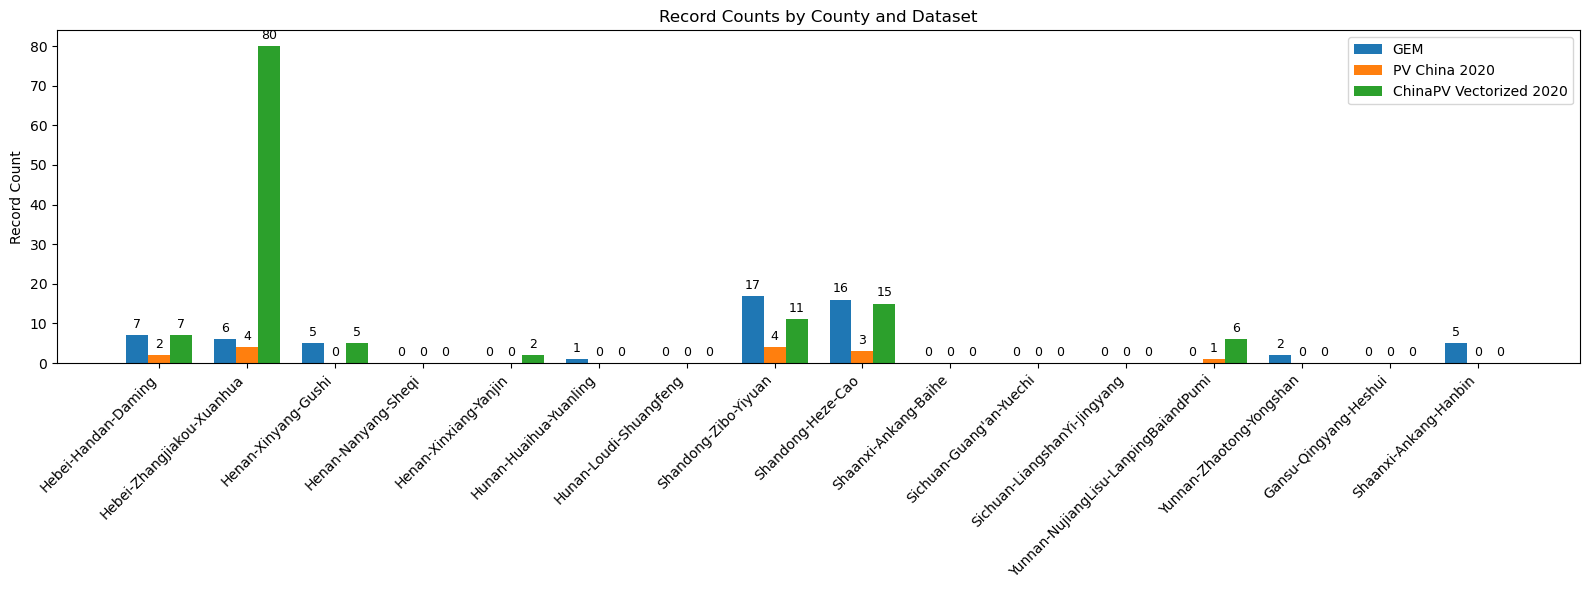

In [32]:
# Plot county_count_records using the county_counts_df DataFrame

county_counts_df['label'] = county_counts_df.apply(
    lambda row: f"{row['province']}-{row['prefecture']}-{row['county']}", axis=1
)

x = range(len(county_counts_df))
width = 0.25

plt.figure(figsize=(16, 6))
bars_gem = plt.bar([i - width for i in x], county_counts_df['GEM_count'], width=width, label='GEM')
bars_pvchina = plt.bar(x, county_counts_df['PVChina2020_count'], width=width, label='PV China 2020')
bars_chinapvvec = plt.bar([i + width for i in x], county_counts_df['ChinaPV_Vectorized2020_count'], width=width, label='ChinaPV Vectorized 2020')

# Add count above each bar
for bars in [bars_gem, bars_pvchina, bars_chinapvvec]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

plt.xticks(x, county_counts_df['label'], rotation=45, ha='right')
plt.ylabel('Record Count')
plt.title('Record Counts by County and Dataset')
plt.legend()
plt.tight_layout()
plt.show()
